In [13]:
import os
import sys
import juliet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import glob
import lightkurve as lk

%matplotlib inline

In [14]:
contr = 0.042967
p1 = 0.4354341  # period in days
perr1 = .0000009  # error on period in days
tc1 = 2459664.03251  # transit midpoint in full JD unit (begins with 24xxxxx)
tcerr1 = .0005296  # transit midpoint in days

### Load Photometry Data

In [15]:
photo_file = './photometry_data/TOI-5278-B.csv'
df = pd.read_csv(photo_file)
print(df.head())
t = np.array(df['time'])
flux = np.array(df['flux'])
flux_err = np.array(df['flux_err'])

flux, flux_err = flux/flux.mean(), flux_err/flux.mean() # normalize flux

times, fluxes, fluxes_error = {},{},{}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t, flux, flux_err

           time      flux  flux_err
0  59713.174262  0.110806  0.001761
1  59713.184147  0.109541  0.001699
2  59713.189911  0.108790  0.001681
3  59713.195675  0.108549  0.001640
4  59713.201439  0.108909  0.001599


### Transit Fit

In [16]:
dataset = juliet.load(priors='./transit_fit_5278/priors.txt', \
                      t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, out_folder = './transit_fit_5278')

results = dataset.fit()

PyMultinest installation not detected. Forcing dynesty as the sampler.


2935it [00:10, 282.89it/s, +500 | bound: 15 | nc: 1 | ncall: 50232 | eff(%):  6.907 | loglstar:   -inf < 37.597 <    inf | logz: 32.540 +/-  0.086 | dlogz:  0.001 >  0.509]


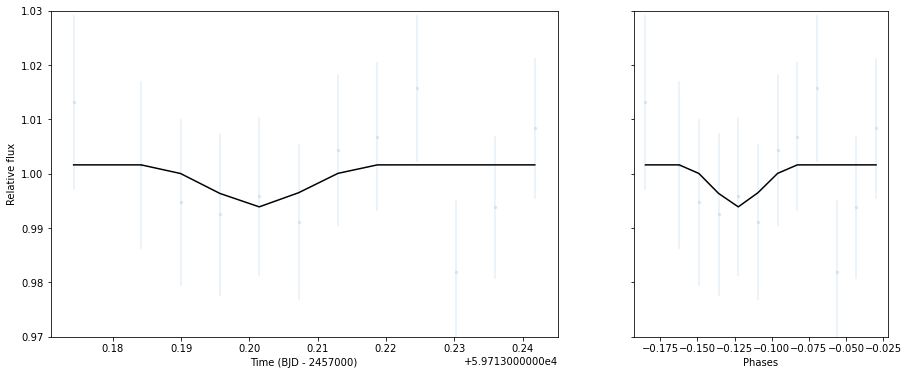

In [17]:
# Extract transit model prediction given the data:
transit_model = results.lc.evaluate('TESS')

# Plot results:
fig = plt.figure(figsize=(15,6))
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1])
ax1 = plt.subplot(gs[0])

# Plot time v/s flux plot:
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \
         yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)

# now plot the model
ax1.plot(dataset.times_lc['TESS'], transit_model,color='black',zorder=10)

ax1.set_ylim([0.97,1.03])
ax1.set_xlabel('Time (BJD - 2457000)')
ax1.set_ylabel('Relative flux')

# Now phased transit lightcurve:
phases = juliet.utils.get_phases(t, p1, tc1)
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, dataset.data_lc['TESS'], \
             yerr = dataset.errors_lc['TESS'], fmt = '.', alpha = 0.1)
idx = np.argsort(phases)
ax2.plot(phases[idx],transit_model[idx], color='black', zorder=10)
ax2.yaxis.set_major_formatter(plt.NullFormatter())
# ax2.set_xlim([-0.018,0.018])
ax2.set_ylim([0.97,1.03])
ax2.set_xlabel('Phases')
plt.show()